<a href="https://colab.research.google.com/github/randyRivera0/LandUseAndWildlifeDLSemanticSegmentation/blob/main/LandUseAndWildlifeDLSemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Cidis LandUseAndWildlifeDLSemanticSegmentation project for Galapagos and ESPOL university](https://www.cidis.espol.edu.ec/sites/default/files/default_images/logo_defecto.png)](https://www.cidis.espol.edu.ec/)
# Train YOLO11 Object Detection on a Custom Galapagos Marine Iguana Dataset
---
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/randyRivera0/LandUseAndWildlifeDLSemanticSegmentation)


[![Roboflow](https://img.shields.io/badge/Roboflow-Dataset-orange)](https://app.roboflow.com/geckos-land/)



Profesor: Phd. Miguel Andrés Realpe Robalino

## Weekly Objectives:

### Tasks
- [ ] Join train, val and test graphics (also scale them)
- [ ] Use best and last pt
- [ ] Test img: separate the labels, boxes and Semantic Segmentation
- [ ] Create new metrics with logs
- [ ] Discover which metrics is using the system to stop the iterations and use the good ones
- [ ] Organize and join collab with github also using a remote running server
- [ ] Lean anout the hauid
- [ ] Use SAM for land segmentation
- [ ] Add more img to val
- [ ] Use jupyter to track progress
- [ ] Show multiple real and predict
- [ ] Small Object Detection
- [ ] Continue with the pretrain
- [ ] Wandb or TensorBoard

### Challenges Faced
- Write something here

### Next Steps
- Integrate Use of Land and develop functionality for biologists


## Setup

In [1]:
!nvidia-smi

Mon Nov 18 15:14:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA TITAN V               WDDM  |   00000000:17:00.0 Off |                  N/A |
| 28%   38C    P8             26W /  250W |       0MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# %conda env export > environment.yml

In [ ]:
import __main__
import sys
import os
from pathlib import Path
import torch
import torchvision
from roboflow import Roboflow
from IPython.display import Image as IPyImage, display
import ultralytics
from ultralytics import YOLO

In [ ]:
# Determine runtime

def in_colab():
    from IPython.core import getipython
    return 'google.colab' in str(getipython.get_ipython())

def is_colab2():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def get_runtime():
    if "google.colab" in sys.modules:
        return "Google Colab"
    elif "ipykernel" in sys.modules:
        if "jupyter" in sys.modules:
            return "JupyterLab"
        else:
            return "Jupyter Notebook"
    elif "win32" in sys.platform:
        if 'CMDEXTVERSION' in os.environ:
            return "Windows Command Prompt"
        else:
            return "Windows PowerShell"          
    elif "darwin" in sys.platform:
        return "MacOS Terminal"
    else:
        if hasattr(__main__,'__file__'):
            return "Linux Terminal"
        else:
            return "Interactive Python Shell"

print(get_runtime())

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Restrict visibility to the TITAN V only


In [4]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print("CUDA disponible:")
    print("Versión de CUDA:", torch.version.cuda)
    gpu_name = torch.cuda.get_device_name(0)
    print("Current device:", torch.cuda.current_device())  # Should output '0'
    print("Device name:", torch.cuda.get_device_name(0))   # Should output 'NVIDIA TITAN V'
else:
    print("No GPU available")

CUDA disponible:
Versión de CUDA: 11.8
Current device: 0
Device name: NVIDIA TITAN V


In [5]:
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [6]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda:0


In [7]:
torch.__version__

'2.5.1'

In [8]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [9]:
torch.cuda.empty_cache()

In [10]:
### NMS Test
print(torch.__version__)
print(torchvision.__version__)
device = 'cuda'
boxes = torch.tensor([[0., 1., 2., 3.]]).to(device)
scores = torch.randn(1).to(device)
iou_threshold = 0.5

print(torchvision.ops.nms(boxes, scores, iou_threshold))


2.5.1
0.20.1
tensor([0], device='cuda:0')


In [11]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [12]:
%export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


UsageError: Line magic function `%export` not found.


In [13]:
ultralytics.checks()
HOME = os.getcwd()

Ultralytics 8.3.31  Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA TITAN V, 12288MiB)
Setup complete  (20 CPUs, 127.7 GB RAM, 718.8/1335.0 GB disk)


In [ ]:
# Initialize Roboflow with your API key
if in_colab():
    ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
    rf = Roboflow(api_key=ROBOFLOW_API_KEY)
else:
    rf = Roboflow(api_key="oO7M6O03cXw3x36PVBxq") # Replace with your actual API key

In [ ]:
!mkdir {HOME}\datasets
%cd {HOME}\datasets

# Get the home directory using pathlib
home = Path.cwd()

# Define the datasets directory path
datasets_dir = home / 'datasets'

# Create the datasets directory (if it doesn't already exist)
datasets_dir.mkdir(parents=True, exist_ok=True)

# Change the current working directory to the datasets directory
# pathlib doesn't have a direct chdir method, so use os.chdir to change the directory
import os
os.chdir(datasets_dir)

# Print the current working directory
print(f"Current directory: {os.getcwd()}")

d:\R\LandUseAndWildlifeDLSemanticSegmentation\datasets


Ya existe el subdirectorio o el archivo d:\R\LandUseAndWildlifeDLSemanticSegmentation\datasets.
This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


## Iguanas

In [ ]:
os.chdir(datasets_dir)

project = rf.workspace("geckos-land").project("galapagosiguanas")
version = project.version(1)
dataset = version.download("yolov11")

d:\R\LandUseAndWildlifeDLSemanticSegmentation\datasets
loading Roboflow workspace...
loading Roboflow project...


In [ ]:
os.chdir(HOME)

!yolo task=detect mode=train model=yolo11l-seg.pt data={dataset.location}/data.yaml epochs=200 imgsz=640 plots=True amp=False

d:\R\LandUseAndWildlifeDLSemanticSegmentation


This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


### Best model


In [22]:
!yolo task=detect mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.31 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA TITAN V, 12288MiB)
YOLO11l-seg summary (fused): 491 layers, 27,585,363 parameters, 0 gradients, 141.9 GFLOPs
                   all          5         54      0.576      0.481      0.496      0.232      0.469      0.389      0.393      0.149
Speed: 0.6ms preprocess, 30.6ms inference, 0.0ms loss, 17.4ms postprocess per image
Results saved to runs\segment\val
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning D:\R\LandUseAndWildlifeDLSemanticSegmentation\datasets\GalapagosIguanas-1\valid\labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
val: Scanning D:\R\LandUseAndWildlifeDLSemanticSegmentation\datasets\GalapagosIguanas-1\valid\labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


In [23]:
!yolo task=detect mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.31 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA TITAN V, 12288MiB)
YOLO11l-seg summary (fused): 491 layers, 27,585,363 parameters, 0 gradients, 141.9 GFLOPs

image 1/3 d:\R\LandUseAndWildlifeDLSemanticSegmentation\datasets\GalapagosIguanas-1\test\images\DJI_0265_MOV-0004_jpg.rf.8c55de2390722f7060e52b9fa7dd270a.jpg: 640x640 12 Iguanas, 20.0ms
image 2/3 d:\R\LandUseAndWildlifeDLSemanticSegmentation\datasets\GalapagosIguanas-1\test\images\DJI_0282_MOV-0004_jpg.rf.16388ec160f464eaab3013907c68df36.jpg: 640x640 15 Iguanas, 21.0ms
image 3/3 d:\R\LandUseAndWildlifeDLSemanticSegmentation\datasets\GalapagosIguanas-1\test\images\DJI_0290_MOV-0002_jpg.rf.93cde8c5d16f7d29642257795e119168.jpg: 640x640 6 Iguanas, 31.0ms
Speed: 4.0ms preprocess, 24.0ms inference, 29.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\p

In [ ]:
IPyImage(filename=f'{HOME}\\runs\\segment\\train2\confusion_matrix.png', width=600)

In [ ]:
IPyImage(filename=f'{HOME}/runs/segment/train5/results.png', width=600)

In [ ]:
IPyImage(filename=f'{HOME}/runs/segment/train2/val_batch0_pred.jpg', width=600)

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict2*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

### Last model

In [25]:
!yolo task=detect mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

^C


WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.31 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA TITAN V, 12288MiB)
YOLO11l-seg summary (fused): 491 layers, 27,585,363 parameters, 0 gradients, 141.9 GFLOPs



val: Scanning D:\R\LandUseAndWildlifeDLSemanticSegmentation\datasets\GalapagosIguanas-1\valid\labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
val: Scanning D:\R\LandUseAndWildlifeDLSemanticSegmentation\datasets\GalapagosIguanas-1\valid\labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]
Exception in thread Thread-4 (plot_images):
Traceback (most recent call last):
  File "C:\Users\Us

## Land Use


In [ ]:
%cd {HOME}/datasets
project = rf.workspace("geckos-land").project("drone-6vm9j")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drone-1 in yolov11:: 100%|██████████| 740/740 [00:00<00:00, 2932.36it/s]


In [ ]:
%cd {HOME}
!yolo task=detect mode=train model=yolo11s-seg.pt data={dataset.location}/data.yaml epochs=10 imgsz=6

/content
WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/content/datasets/Drone-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=6, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=

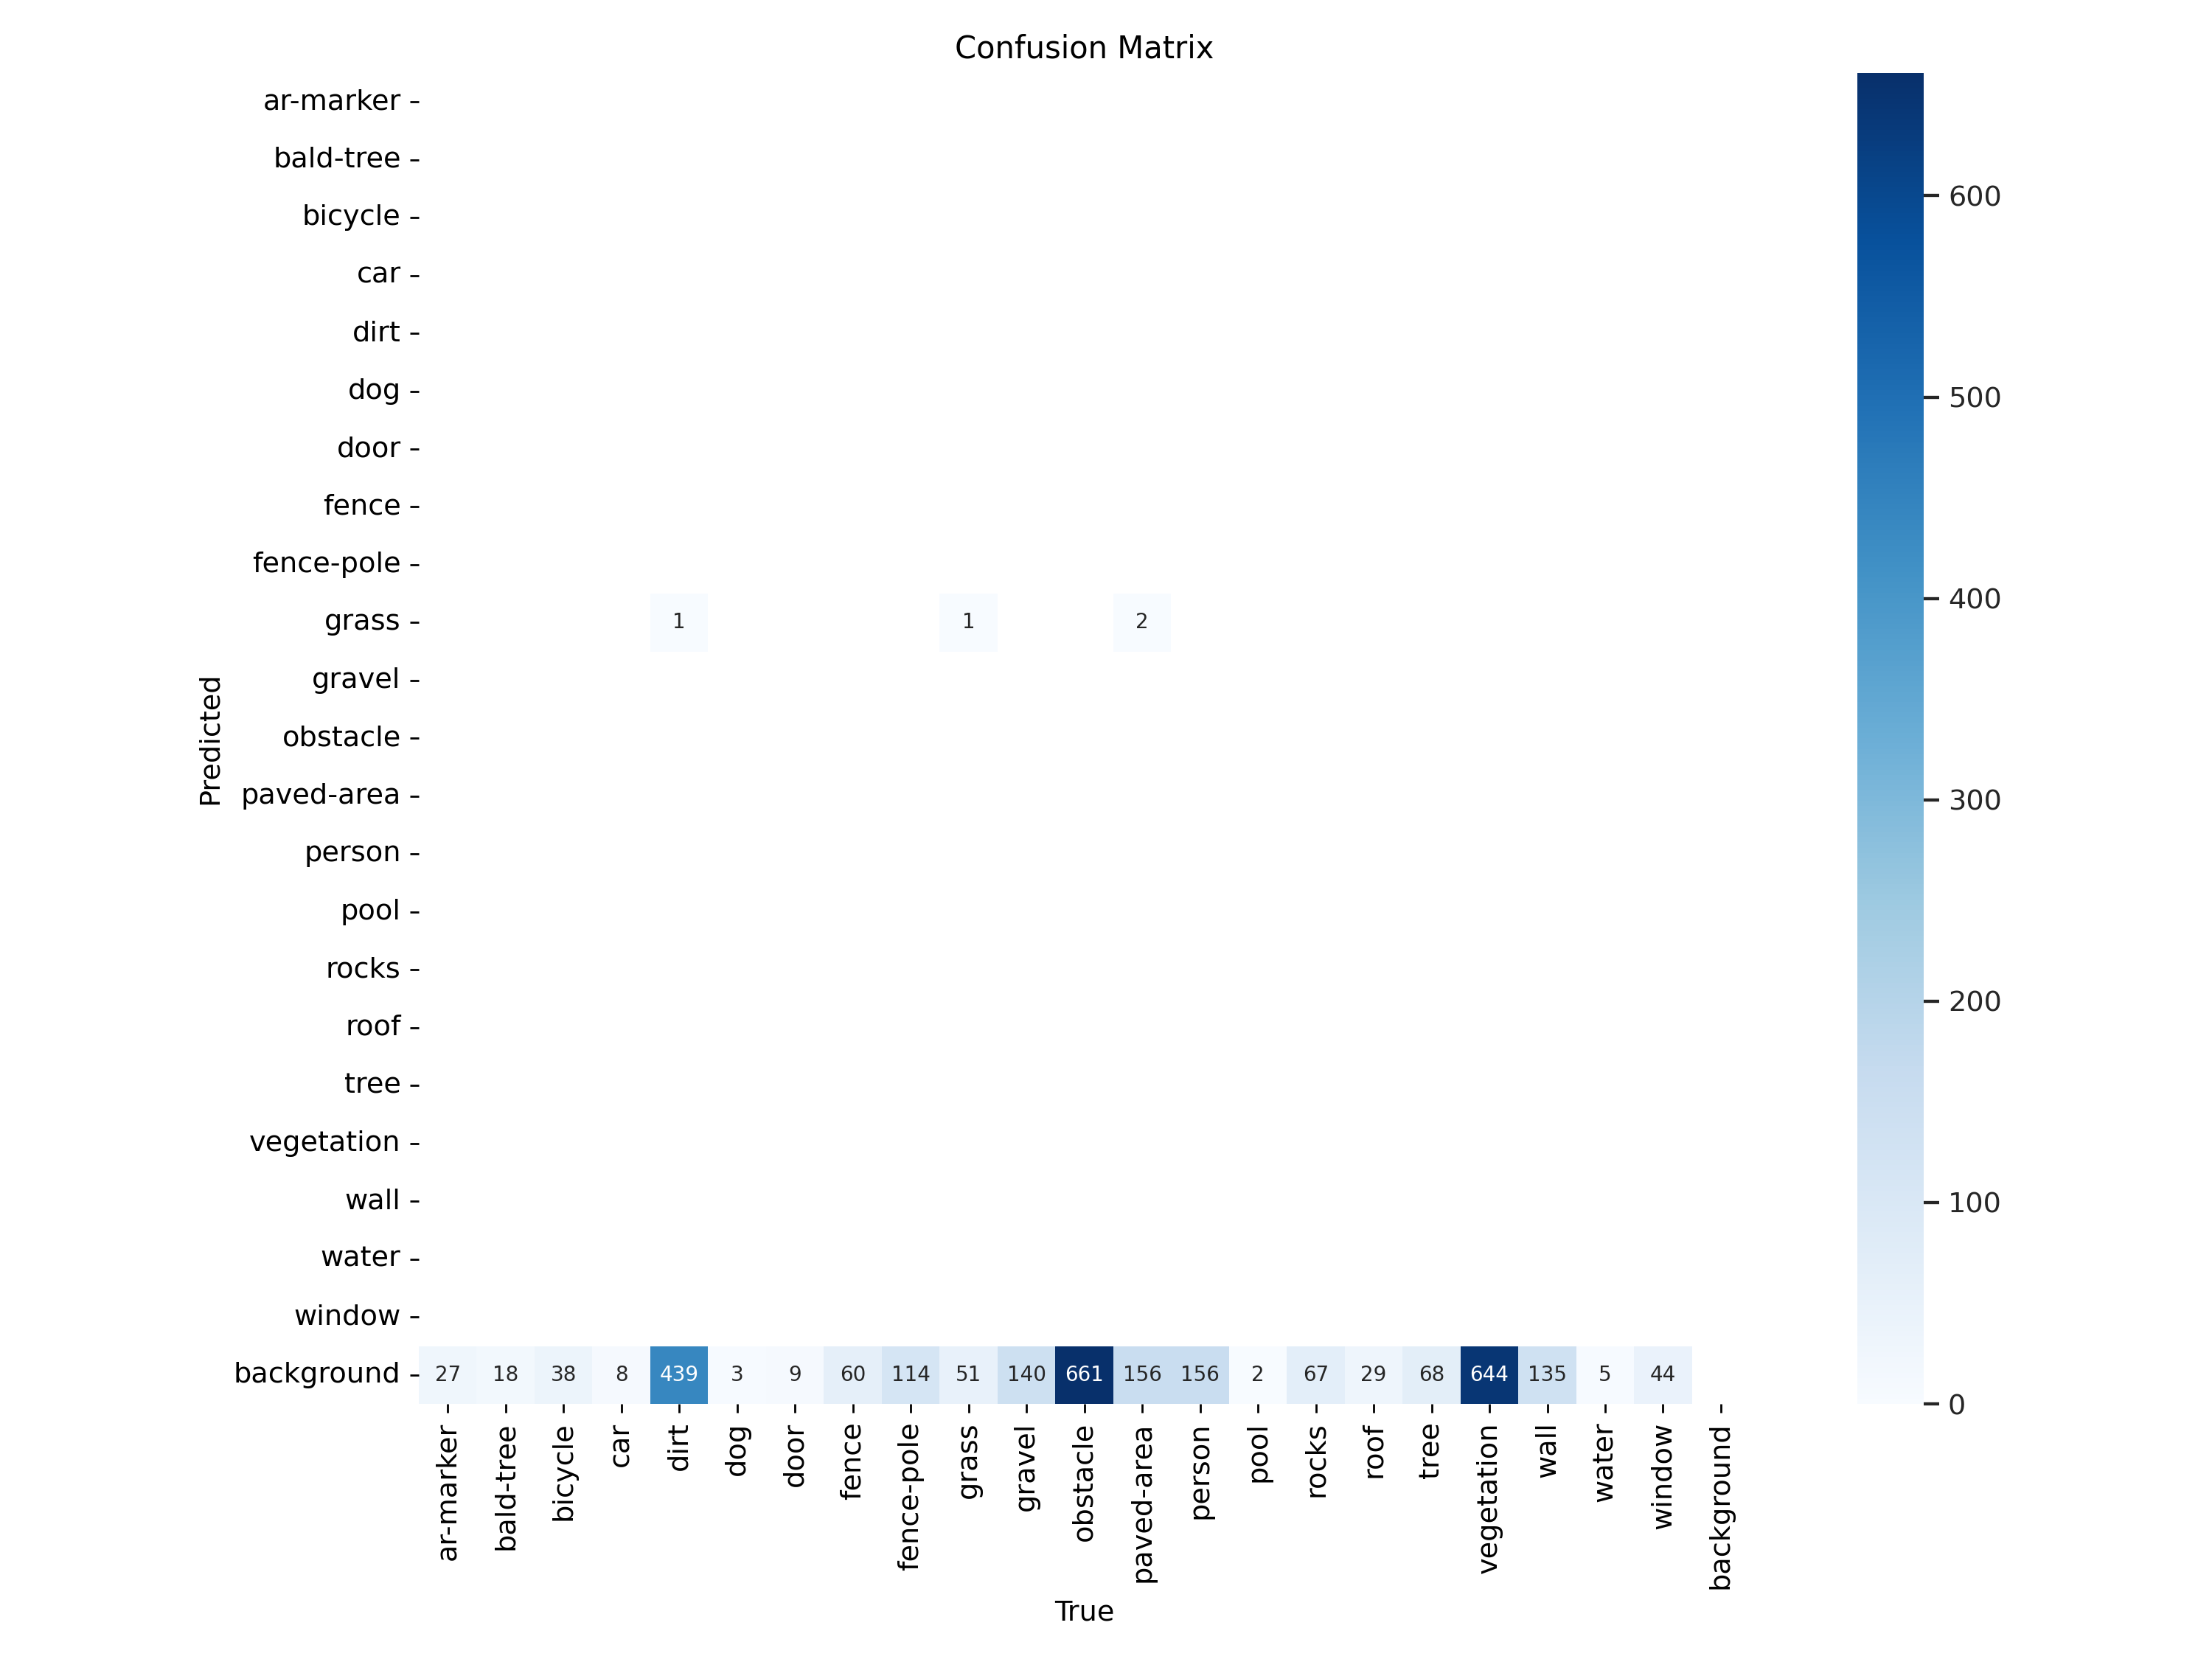

In [ ]:
IPyImage(filename=f'{HOME}/runs/segment/train3/confusion_matrix.png', width=600)


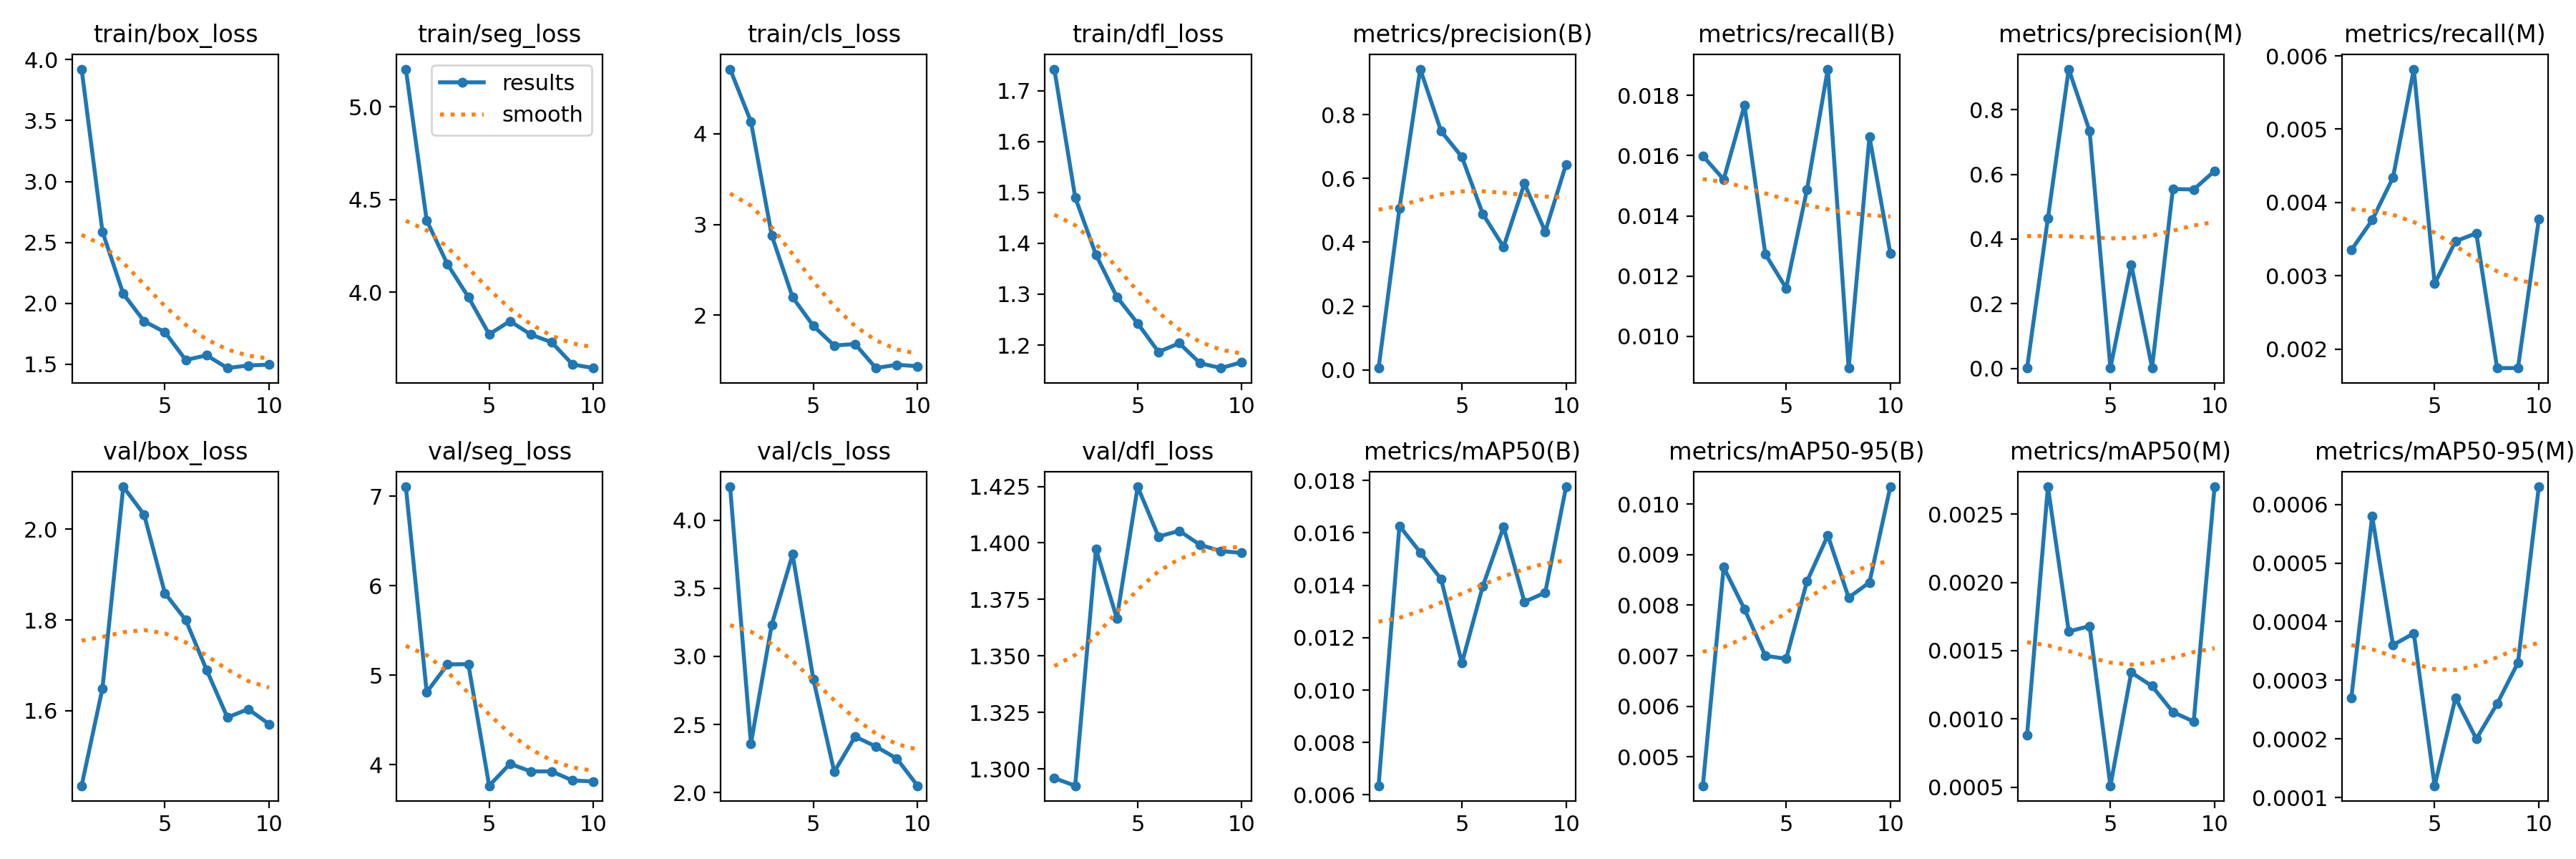

In [ ]:
IPyImage(filename=f'{HOME}/runs/segment/train3/results.png', width=600)

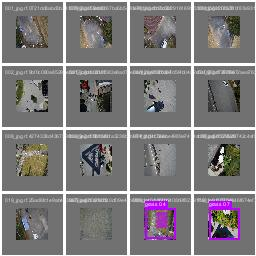

In [ ]:
IPyImage(filename=f'{HOME}/runs/segment/train3/val_batch0_pred.jpg', width=600)

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/segment/train3/weights/best.pt data={dataset.location}/data.yaml


WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s-seg summary (fused): 265 layers, 10,075,330 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /content/datasets/Drone-1/valid/labels.cache... 37 images, 0 backgrounds, 0 corrupt: 100% 37/37 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.05s/it]
                   all         37       2878      0.644     0.0128     0.0178     0.0104      0.611    0.00377     0.0027   0.000634
             ar-marker         15         27          0          0          0          0          0          0          0          0
             bald-tree          7         18          1          0          0          0          1          0          0      

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/segment/train3/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s-seg summary (fused): 265 layers, 10,075,330 parameters, 0 gradients, 35.3 GFLOPs

image 1/19 /content/datasets/Drone-1/test/images/022_jpg.rf.66e653a53721e842cf2e057954102676.jpg: 32x32 1 paved-area, 13.5ms
image 2/19 /content/datasets/Drone-1/test/images/047_jpg.rf.e5501bf439a8c2f23c636ff699b0e2fa.jpg: 32x32 1 paved-area, 10.2ms
image 3/19 /content/datasets/Drone-1/test/images/052_jpg.rf.81fdff90dbc4f08f98f56536ba76d5c1.jpg: 32x32 1 grass, 9.3ms
image 4/19 /content/datasets/Drone-1/test/images/057_jpg.rf.b73c4cd678f5e7bc261e2616b4efd5ec.jpg: 32x32 1 paved-area, 8.5ms
image 5/19 /content/datasets/Drone-1/test/images/063_jpg.rf.59823214f03b7715b98596acebe912b3.jpg: 32x32 1 grass, 8.8ms
image 6/19 /content/datasets/Drone-1/test/images/075_jpg.rf.10364e7aad4ed79

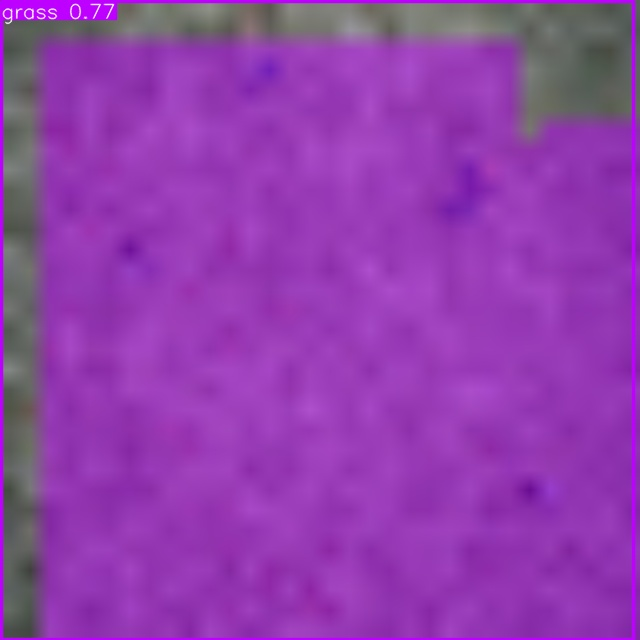

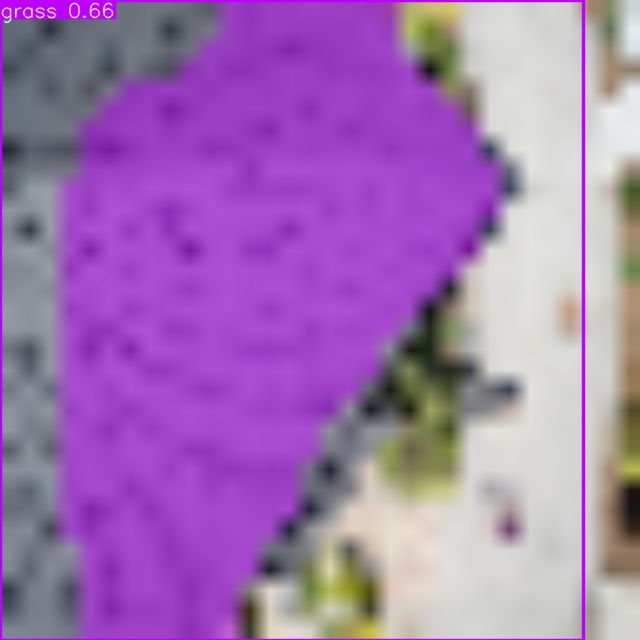

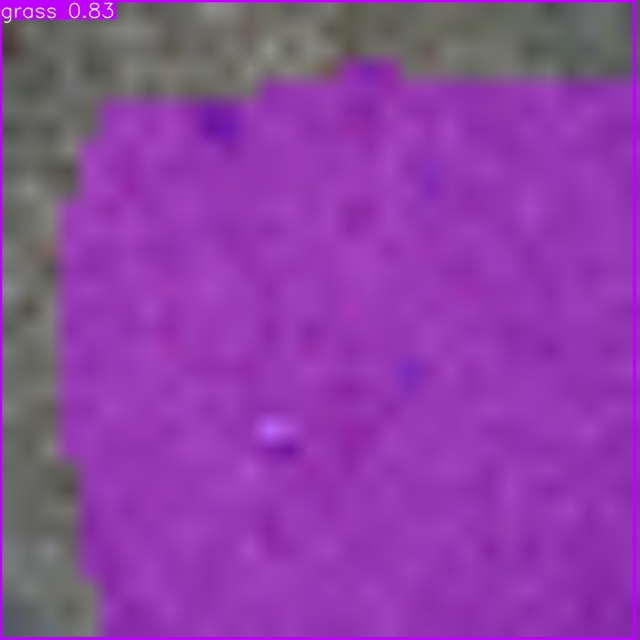

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict4*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## References
1. Roboflow. (2024). *Roboflow Notebooks: How to Train YOLO11 Object Detection on a Custom Dataset*. Retrieved from https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb
how-to-train-yolov8-instance-segmentation/
2. Roboflow. (). *Roboflow Notebooks: How to Train YOLO11 Instance Segmentation on a Custom Dataset* Retrieved from https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolo11-instance-segmentation-on-custom-dataset.ipynb
3. Ultralytics. (). *Model Training with Ultralytics YOLO* Retrieved from https://docs.ultralytics.com/modes/train/
4. Ultralytics. *Model Training with Ultralytics YOLO* Retrieved from https://blog.roboflow.com/how-to-use-roboflow-with-aerial-imagery/
5. Tugraz. *Semantic Drone Dataset* Retrieved from http://dronedataset.icg.tugraz.at/
6. Ayushdabra. *Model Training with Ultralytics YOLO* Retrieved from https://github.com/ayushdabra/drone-images-semantic-segmentation
7. Noostale. *Model Training with Ultralytics YOLO* Retrieved from https://github.com/noostale/drone-semantic-segmentation. 
8. Open Business Software Solutions. (). *slicing aided hyper inference and fine-tuning for small object detection* Retrieved from https://github.com/obss/sahi.

